# Predicting Medical Insurance Costs Using OLS, SVR, and Polynomial Features

## Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. Exploring the Data](#2.-Exploring-the-Data)
- [3. Dividing the Dataset](#3.-Dividing-the-Dataset)
- [4. Building the OLS Model](#4.-Building-the-OLS-Model)
- [5. Diagnosing Residuals in the OLS Model](#5.-Diagnosing-Residuals-in-the-OLS-Model)
- [6. Interpreting and Evaluating the OLS Model](#6.-Interpreting-and-Evaluating-the-OLS-Model)
- [7. Enhancing Predictions with SVR and Polynomial Features](#7.-Enhancing-Predictions-with-SVR-and-Polynomial-Features)
- [8. Conclusion](#8.-Conclusion)

## 1. Introduction

In this project, we'll be examining the [Medical Cost Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance?) from [Kaggle](https://www.kaggle.com/). This dataset contains information about individual medical insurance bills, with each bill linked to various demographic and personal characteristics of the patient who received it.

For our predictive modeling problem, we are interested in how these different characteristics relate to the total medical insurance cost. Since the cost is a continuous, positive number, it is well-suited for regression analysis. Additionally, our goal is to construct various predictive models for the cost, using the OLS model as our baseline, and compare their performance.

Predicting medical insurance costs is a crucial task because it enables hospitals to forecast revenue and plan necessary procedures for their patient population. Here are the columns in the dataset:
- **age** – Age of the primary beneficiary.
- **sex** – Gender of the insurance contractor (`male` or `female`).
- **bmi** – Body Mass Index (`BMI`), ideally ranging from `18.5` to `24.9`.
- **children** – Number of children or dependents covered by health insurance.
- **smoker** – Smoking status.
- **region** – Beneficiary's residential area in the `U.S.` (`Northeast`, `Southeast`, `Southwest`, or `Northwest`).
- **charges** – Individual medical costs billed by health insurance (in `USD`).

Let's start by importing the necessary libraries, loading the data, and taking a quick look at it.

In [1]:
# Import the relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Load the insurance dataset into a DataFrame and display the first few rows
insurance = pd.read_csv("Datasets/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Display a summary of the dataset, including column types and non-null counts
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset contains `1,338` entries with no missing values across `7` columns. The data types include `integers`, `floats`, and `objects`, indicating a mix of numerical and categorical data. Moreover, the first five rows show a diverse set of individuals with varying ages, BMIs, and numbers of children. The data includes both male and female patients from different `U.S.` regions.

## 2. Exploring the Data

To select the most promising features for potential use, we'll explore which variables are highly correlated with the outcome. However, if two predictors are highly correlated with each other, it might be beneficial to select only the one that produces the better model.

To get started, let's explore the distribution of the `charges` column since represents the outcome.

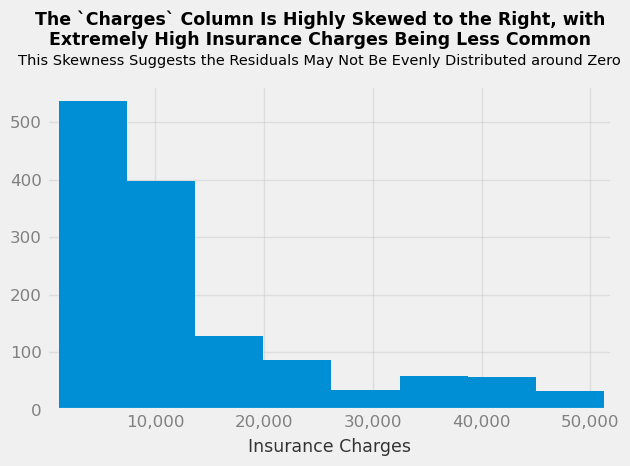

In [3]:
# Set plot style to 'fivethirtyeight', and specify figure size
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6.5, 4))

# Plot a histogram for the 'charges' column
plt.hist(insurance['charges'])

# Add a main title and a subtitle
plt.suptitle('The `Charges` Column Is Highly Skewed to the Right, with\n\
Extremely High Insurance Charges Being Less Common',
             x=0.5, y=1.07, size=12.5, ha='center', weight='bold')
plt.title('This Skewness Suggests the Residuals May Not Be Evenly Distributed around Zero',
          x=0.482, y=1.04, size=10.5, ha='center')

# Customize x limits, ticks and gridlines for both axes, and add x-axis label
plt.xlim(0, 52000)
plt.xticks(ticks=range(0, 60000, 10000), labels=['', '10,000', '20,000', '30,000', '40,000', '50,000'],
           size=12, c='grey')
plt.yticks(size=12, c='grey')
plt.xlabel('Insurance Charges', c='#333333', labelpad=6, size=12.5)
plt.grid(alpha=0.5)

# Display the plot
plt.show()

The `charges` column is highly skewed to the right, with extremely high insurance charges being less common. This skewness suggests that the residuals of our baseline OLS model may not form an **even band** around zero when plotted against the predicted values. Extreme values in the dependent variable can influence the estimated coefficients and cause residuals to deviate from constant variance.

Therefore, it's beneficial to log-transform the outcome. This transformation involves predicting the log of the outcome instead of the outcome itself.

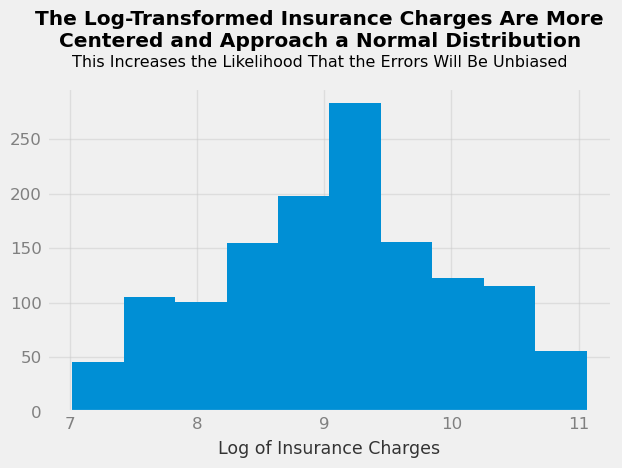

In [4]:
# Apply log transformation to the 'charges' column, and create a new column 'log_charges'
insurance["log_charges"] = np.log(insurance["charges"])

# Specify figure size and plot a histogram of the log-transformed charges
plt.figure(figsize=(6.5, 4))
plt.hist(insurance['log_charges'])

# Add a main title and a subtitle
plt.suptitle('The Log-Transformed Insurance Charges Are More\n\
Centered and Approach a Normal Distribution',
             x=0.5, y=1.075, size=14.5, ha='center', weight='bold')
plt.title('This Increases the Likelihood That the Errors Will Be Unbiased',
          x=0.482, y=1.04, size=11.5, ha='center')

# Customize ticks and gridlines for both axes, and add x-axis label
plt.xlabel('Log of Insurance Charges', c='#333333', labelpad=6, size=12.5)
plt.xticks(ticks=range(7,12), labels=range(7,12), size=12, c='grey')
plt.yticks(size=12, c='grey')
plt.grid(alpha=0.5)

# Display the plot
plt.show()

The log-transformed insurance charges are more centered and approach a normal distribution. This increases the likelihood that the errors will be unbiased. Next, we're going to check the correlation between the numerical columns in the insurance data.

In [5]:
# Select numeric columns and calculate their correlation matrix
insurance_numeric = insurance.select_dtypes(include=['number'])
insurance_numeric.corr().iloc[:, :3]

,age,bmi,children
age,1.000000,0.109272,0.042469
bmi,0.109272,1.000000,0.012759
children,0.042469,0.012759,1.000000
charges,0.299008,0.198341,0.067998
log_charges,0.527834,0.132669,0.161336


The correlation matrix reveals that age has a moderate positive correlation with both `charges` (`0.30`) and `log_charges` (`0.53`), suggesting that older individuals tend to have higher medical costs. BMI shows a weaker correlation with `charges` (`0.20`) and `log_charges` (`0.13`). The number of children covered by health insurance has a very weak correlation with `charges` (`0.07`) and `log_charges` (`0.16`). Additionally, the `charges` and `log_charges` are highly correlated (`0.89`), which is expected since `log_charges` is derived from `charges`.

In linear regression models, categorical variables represent changes in the average target value when an observation belongs to a non-reference category. To visualize this, box plots of the target variable, stratified by the categories, can effectively show differences in distribution and central tendency across groups.

If there is a significant difference in the target variable's distribution across categories, it may be worth including that categorical variable in the model.

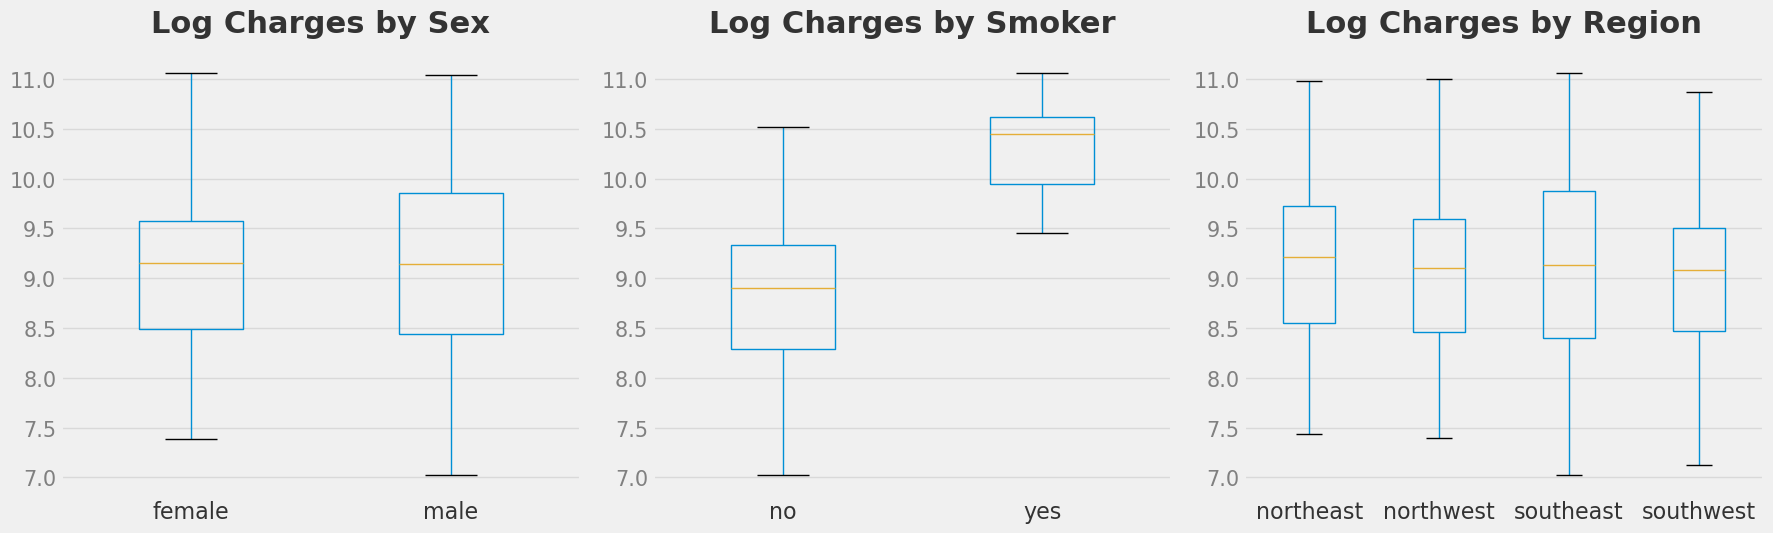

In [6]:
# Define the variables for plotting and their corresponding titles
plot_info = [("sex", "Log Charges by Sex"), 
             ("smoker", "Log Charges by Smoker"), 
             ("region", "Log Charges by Region")]

# Create subplots for the three boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each subplot, variable, and title
for ax, (col, title) in zip(axes, plot_info):
    
    # Create a boxplot of 'log_charges' for the specified column and customize plot appearance
    insurance.boxplot("log_charges", by=col, ax=ax, widths=0.4)
    ax.set_title(title, color='#333333', weight='bold', size=22, pad=15)
    ax.tick_params(axis='y', colors='grey', labelsize=15)
    ax.tick_params(axis='x', colors='#333333', labelsize=16)
    ax.set_xlabel("")
    ax.grid(axis='x', visible=False)
    ax.grid(axis='y', color='grey', alpha=0.2)

# Remove the super title and display the plots
plt.tight_layout()
plt.suptitle('')
plt.show()

Based on the boxplots, males appear to have a slightly wider distribution of charges compared to females, and smokers incur significantly higher costs than non-smokers. While there don't seem to be many appreciable differences between regions, the Southeast has the widest distribution of values.

Based on the univariate relationships observed, the columns `age`, `bmi`, and `smoker` are positively associated with higher insurance charges. Therefore, we'll include these predictors in the models we are going to build. However, we need to convert the values in `smoker` to binary format.

## 3. Dividing the Dataset

Before we build our OLS linear regression model, we need to divide the insurance dataset into two parts:
1. A training set, used to estimate the regression coefficients for each predictor.
2. A test set, used to assess the model's predictive ability.

It is crucial that the test dataset is not used to estimate the coefficients, as it represents new, unseen data for making predictions. Instead, the prediction error on the test set helps us assess how well a model generalizes.

In [7]:
# Convert 'smoker' to a binary 'is_smoker' column and display unique values
insurance["is_smoker"] = insurance["smoker"] == "yes"
display(insurance["is_smoker"].unique())

# Define feature variables (X) and target variable (y)
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

array([ True, False])

As we can see, the `is_smoker` column successfully categorizes individuals into two groups – smokers (`True`) and non-smokers (`False`).

## 4. Building the OLS Model

Now that we have divided the data into training and test sets, we’re ready to build our predictive OLS linear model. After constructing the model, we will examine the coefficient of determination (`R²`) and the root mean squared error (`RMSE`) on the original scale for the training set.

In [8]:
# Initialize and train the OLS linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the target variable using the training data
train_pred = model.predict(X_train)

# Print RMSE on the original scale and R-squared score for the training set
print(f"Root mean squared error (train set): {root_mean_squared_error(np.exp(y_train), np.exp(train_pred)):.2f}")
print(f"R-squared score (train set): {r2_score(y_train, train_pred):.4f}")

Root mean squared error (train set): 8255.60
R-squared score (train set): 0.7433


The training `RMSE` for the OLS model is `8255.60`, indicating how far, on average, the predictions are from the true insurance charges. The training `R²` value indicates that the model explains `74.33%` of the variation in the log-insurance charges. While these preliminary training results look promising, it's important to note that they may be optimistic.

## 5. Diagnosing Residuals in the OLS Model

We now have a predictive OLS model for medical insurance costs. Before we examine it more closely, we should check how well the assumptions of linear regression are met. The error term `𝜖ᵢ` represents how much the outcome `𝑌ᵢ` differs from the prediction made by the combination of predictors:

$$ \epsilon_i = Y_i - (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) $$

Since residuals should exhibit similar characteristics to the `𝜖ᵢ`, we'll examine the residuals for the training data and plot them against the fitted values on a scatter plot.

In [9]:
# Create a DataFrame to analyze residuals and fitted values, and display the first few rows
residual_analysis = pd.DataFrame()
residual_analysis["residuals"] = np.exp(y_train) - np.exp(train_pred)
residual_analysis["fitted"] = np.exp(train_pred)
residual_analysis.head()

,residuals,fitted
693,-1189.469953,3542.438403
1297,133.316363,4207.124537
634,-1528.739116,10920.085116
1022,-632.400731,42843.538931
178,679.377772,8143.901228


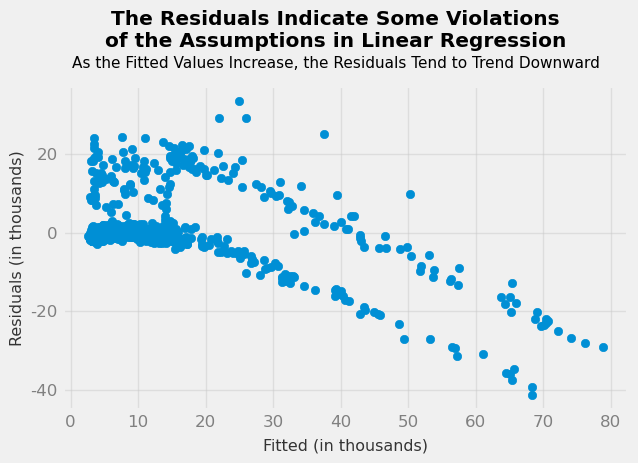

In [10]:
# Plot residuals against fitted values to assess the OLS model's fit
plt.figure(figsize=(6.5, 4))
plt.scatter(residual_analysis['fitted'], residual_analysis['residuals'])

# Add a main title and a subtitle
plt.suptitle('The Residuals Indicate Some Violations\nof the Assumptions in Linear Regression',
             x=0.5, y=1.07, size=14.5, ha='center', weight='bold')
plt.title('As the Fitted Values Increase, the Residuals Tend to Trend Downward',
          x=0.483, y=1.03, size=11, ha='center')

# Customize ticks and gridlines, and add labels for both axes
plt.xticks(ticks=range(0, 90000, 10000), labels=range(0, 90, 10), size=12, c='grey')
plt.yticks(ticks=range(-40000, 40000, 20000), labels=range(-40, 40, 20), size=12, c='grey')
plt.xlabel('Fitted (in thousands)', c='#333333', labelpad=6, size=11.5)
plt.ylabel('Residuals (in thousands)', c='#333333', size=11.5)
plt.grid(alpha=0.5)

# Display the plot
plt.show()

The residuals indicate some violations of the assumptions in linear regression. As the fitted values increase, the residuals tend to trend downward. Moreover, the residuals mostly become negative once the fitted values surpass around `40,000`, indicating that the OLS model tends to overpredict at higher values.

Ideally, we expect an even band centered around zero. While this issue doesn't necessarily render the OLS model's predictions unusable, it does call into question the validity of some linear regression assumptions.

## 6. Interpreting and Evaluating the OLS Model

One of the best qualities of a linear model is that we can easily interpret the estimated coefficients. The model provides a way to discuss how changes in the predictors relate to changes in the outcome (without implying causation). For a linear model with multiple predictors:

$$ Y_i = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p + \epsilon_i $$

We would interpret `β₁` as the average increase in `𝑌` for a unit increase in `𝑋₁`, holding the other predictors constant. This reasoning can be applied to each of the variables in the model.

From a hospital administrator's perspective, the regression coefficients might represent actionable plans to improve the efficiency of medical care. For example, they might consider reallocating resources to a hospital with a particularly vulnerable patient population based on the model's interpretations.

In [11]:
# Calculate the estimated coefficients for the OLS model
print(model.coef_.round(4), end='\n\n')

# Calculate the impact of each variable on insurance charges as a percentage change
variables = ["age", "bmi", "is_smoker"]

for coef, var in zip(model.coef_, variables):
    percentage_change = round(100 * (np.exp(coef) - 1), 2)
    print(f'Percentage change in insurance charges due to "{var}": {percentage_change}%')

[0.0353 0.0108 1.5472]

Percentage change in insurance charges due to "age": 3.59%
Percentage change in insurance charges due to "bmi": 1.09%
Percentage change in insurance charges due to "is_smoker": 369.83%


Here's what we can learn from the output above:
- A one-year increase in age is associated with a `0.035` increase in `log_charges`, holding `is_smoker` and `bmi` constant. This translates to about a `3.59%` increase in the insurance charges on the regular scale.
- A one-unit increase in BMI is associated with a `0.011` increase in `log_charges`, holding `is_smoker` and `age` constant. This translates to about a `1.09%` increase in the insurance charges on the regular scale.
- Being a smoker is associated with a `1.55` increase in `log_charges`, holding `age` and `bmi` constant. This translates to a dramatic `369.83%` increase in the insurance charges on the regular scale.

Since our primary goal is prediction, we are not focused on the statistical significance of these changes, so we don't know if these associations are truly non-zero. Next, we need to evaluate how the OLS model performs on the test data, which consists of new observations that the model hasn't seen during training.

In [12]:
# Make predictions on the test set
test_pred = model.predict(X_test)

# Print RMSE on the original scale and R-squared score for the test set
print(f"Root mean squared error (test set): {root_mean_squared_error(np.exp(y_test), np.exp(test_pred)):.2f}")
print(f"R-squared score (test set): {r2_score(y_test, test_pred):.4f}")

Root mean squared error (test set): 8476.36
R-squared score (test set): 0.7481


The model's performance is very similar on both the training and test data, with the `RMSE` and `R-squared` score being nearly identical for both sets, indicating similar prediction accuracy and error on the original scale. Based on these metrics, we can conclude that the OLS linear regression model is not overfitted.

## 7. Enhancing Predictions with SVR and Polynomial Features

To create more accurate models, we can use Support Vector Regression (SVR) and generate polynomial features to include more complex terms, such as interaction or quadratic terms.

First, we will build the SVR model after scaling our predictors to improve performance, while keeping `log_charges` as the target variable.

In [13]:
# Scale predictors using StandardScaler for training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVR model on scaled training features with a radial basis function kernel
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Make predictions for both training and test sets
y_train_pred = svr_model.predict(X_train_scaled)
y_test_pred = svr_model.predict(X_test_scaled)

# Calculate RMSE on the original scale and R² score for training and test sets
rmse_train = root_mean_squared_error(np.exp(y_train), np.exp(y_train_pred))
rmse_test = root_mean_squared_error(np.exp(y_test), np.exp(y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the performance metrics for both sets
print(f"Training Set - RMSE: {rmse_train:.2f}, R² score: {r2_train:.4f}")
print(f"Test Set - RMSE: {rmse_test:.2f}, R² score: {r2_test:.4f}")

Training Set - RMSE: 4832.53, R² score: 0.8022
Test Set - RMSE: 5027.99, R² score: 0.7913


The SVR model performs significantly better than the OLS model on both the training and test sets, with lower `RMSE` and higher `R²` values. The similar performance of the SVR model on both sets indicates a good fit without significant overfitting, with the test `R²` showing that the model explains `79.13%` of the variation in the log-insurance charges.

Although we’ll use the same predictors as before, we’ll now use the `charges` column as the target variable to build our polynomial features model. After splitting the data, we will scale the polynomial features for the training and test sets before fitting the linear regression model on the scaled features.

In [14]:
# Set 'charges' as the target variable and split data into training and test sets
y = insurance["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Generate polynomial features (including interaction and quadratic terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Scale polynomial features for training and test sets
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Fit linear regression model on scaled polynomial features
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)

# Make predictions for both training and test sets
y_train_pred = model.predict(X_train_poly_scaled)
y_test_pred = model.predict(X_test_poly_scaled)

# Calculate RMSE on the original scale and R² score for training and test sets
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the performance metrics for both sets
print(f"Training Set - RMSE: {rmse_train:.2f}, R² score: {r2_train:.4f}")
print(f"Test Set - RMSE: {rmse_test:.2f}, R² score: {r2_test:.4f}")

Training Set - RMSE: 4892.36, R² score: 0.8350
Test Set - RMSE: 4762.74, R² score: 0.8497


The polynomial features model performs the best on both the training and test sets, with lower `RMSE` and higher `R²` values. Interestingly, the model performs slightly better on the test set, indicating a good fit without overfitting. Furthermore, the test `R²` score shows that the model explains `84.97%` of the variation in the log-insurance charges.

## 8. Conclusion

In this project, we analyzed the [Medical Cost Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance), which includes individual medical insurance bills linked to various demographic and personal characteristics of patients. Our goal was to construct predictive models for the costs, using the OLS model as a baseline, and compare their performance. Predicting medical insurance costs is essential for hospitals to forecast revenue and plan necessary procedures for their patient population.

The dataset contains `1,338` entries with no missing values across `7` columns, representing a mix of numerical and categorical data. It features a diverse group of individuals with varying ages, BMIs, and numbers of children, including both male and female patients from different U.S. regions. Upon examining the `charges` column, which represents the outcome, we found it highly skewed to the right, with extreme insurance charges being less common. To address this, we log-transformed the `charges` column, resulting in log-transformed costs that are more centered and closer to a normal distribution.

We examined the numerical variables correlated with the outcome. For categorical variables, we used box plots of the target variable, stratified by categories, to illustrate differences in distribution and central tendency across groups. The univariate relationships showed that age, BMI, and smoking status are positively associated with higher insurance charges. Consequently, we included these predictors in our models and converted the `smoker` values to a binary format. To start building our models, we split the insurance dataset into training and test sets. For each model, we evaluated the coefficient of determination (`R²`) and the root mean squared error (`RMSE`) on the original scale for both sets.

For the OLS linear model, we checked how well the assumptions of linear regression were met by examining the residuals for the training data and plotting them against the fitted values. The residuals showed some violations, trending downward as fitted values increased, with overprediction at higher values. While this doesn't make the OLS model's predictions unusable, we would ideally expect a more even band around zero. Next, we calculated the estimated coefficients and the percentage change in insurance charges for each variable. Since our primary goal was prediction, we didn’t focus on the statistical significance of these changes, so we can't confirm if the associations are truly non-zero.

To improve model accuracy, we used Support Vector Regression (SVR) and generated polynomial features for more complex terms. For the SVR model, we scaled the predictors and kept `log_charges` as the target variable, while for the polynomial model, we used `charges` as the target variable. Finally, here’s a table displaying the performance metrics for the OLS, SVR, and polynomial features models:

| Model           | Target Variable | RMSE (Train) | R² (Train) | RMSE (Test) | R² (Test) |
|:----------------|-----------------|--------------|------------|-------------|-----------|
| **OLS**         | log_charges     | 8255.60      | 74.33%     | 8476.36     | 74.81%    |
| **SVR**         | log_charges     | 4832.53      | 80.22%     | 5027.99     | 79.13%    |
| **Polynomials** | charges         | 4892.36      | 83.50%     | 4762.74     | 84.97%    |

In summary, the SVR and polynomial features models perform significantly better than the OLS model, with the polynomial model being the best performer, achieving a test `RMSE` of `4762.74` and a test `R²` score of `84.97%`. Although the target variables for the OLS and SVR models are log-scaled, their `RMSE` was calculated on the original scale. This provides a more interpretable measure of prediction error, allowing for easier assessment of the model's performance in terms of actual insurance costs (in `USD`) rather than transformed values.